In [1]:
import pickle

import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from tensorflow.keras import layers

from nils.reconstruction_module import cleanup_formfactor
from nils.simulate_spectrometer_signal import get_crisp_signal

## Load and Preprocess Data

In [2]:
with open("ocelot80k.pkl", "rb") as file:
    data = pickle.load(file)

In [3]:
currents = [(sample["s"][:1000], sample["I"][:1000]) for sample in data]
del data

In [4]:
# Only keep samples with current profiles that exceed 1 kA
filtered = [(s, current) for s, current in currents if current.max() > 1000]
len(filtered)

20335

In [5]:
# Shift center of mass of each current profile onto the origin

def shift_onto_center_of_mass(s, current):
    """Shift a current profile such that its center of mass it at 0."""
    cm = (s * current).sum() / current.sum()
    return s - cm, current

shifted = [shift_onto_center_of_mass(s, current) for s, current in filtered]

In [6]:
# Interpolate all current profiles onto the same samples of s

limit = max(max(np.abs(s)) for s, _ in shifted)
new_s = np.linspace(-limit, limit, 1000)

interpolated = [(new_s, np.interp(new_s, s, current, left=0, right=0)) for s, current in shifted]

In [7]:
# Make formfactors
def current2formfactor(s, current):
    """Convert a current to its corresponding cleaned form factor."""
    frequency, formfactor, formfactor_noise, detlim = get_crisp_signal(s, current, n_shots=10, which_set="both")
    clean_frequency, clean_formfactor, _ = cleanup_formfactor(frequency, formfactor, formfactor_noise, detlim, channels_to_remove=[])

    return clean_frequency, clean_formfactor

formfactors = [current2formfactor(*current) for current in interpolated]

/usr/local/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [8]:
X = np.stack([formfactor for _, formfactor in formfactors])
y = np.stack([current for _, current in interpolated])

## Training

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

In [10]:
ff_scaler = MinMaxScaler()
X_train_scaled = ff_scaler.fit_transform(X_train)

current_scaler = 1 / y_train.max(axis=1).mean()
y_train_scaled = y_train * current_scaler

In [11]:
model = keras.Sequential([layers.Dense(200, activation="relu"),
                          layers.Dense(100, activation="relu"),
                          layers.Dense(50, activation="relu"),
                          layers.Dense(y_train.shape[1])])
model.compile(optimizer="adam", loss="mse", metrics=["mae"])

In [12]:
history = model.fit(X_train_scaled, y_train_scaled, epochs=500, batch_size=64, validation_split=0.25)

/191 [==============================] - 1s 7ms/step - loss: 5.9156e-04 - mae: 0.0060 - val_loss: 8.8440e-04 - val_mae: 0.0069
Epoch 362/500
191/191 [==============================] - 1s 7ms/step - loss: 6.0288e-04 - mae: 0.0061 - val_loss: 8.5249e-04 - val_mae: 0.0067
Epoch 363/500
191/191 [==============================] - 1s 6ms/step - loss: 6.0359e-04 - mae: 0.0061 - val_loss: 8.5919e-04 - val_mae: 0.0068
Epoch 364/500
191/191 [==============================] - 1s 6ms/step - loss: 5.8804e-04 - mae: 0.0060 - val_loss: 8.3969e-04 - val_mae: 0.0066
Epoch 365/500
191/191 [==============================] - 1s 7ms/step - loss: 6.2211e-04 - mae: 0.0062 - val_loss: 8.6610e-04 - val_mae: 0.0068
Epoch 366/500
191/191 [==============================] - 1s 8ms/step - loss: 6.1938e-04 - mae: 0.0061 - val_loss: 8.5383e-04 - val_mae: 0.0067
Epoch 367/500
191/191 [==============================] - 1s 6ms/step - loss: 6.1140e-04 - mae: 0.0061 - val_loss: 8.4047e-04 - val_mae: 0.0066
Epoch 368/500
19

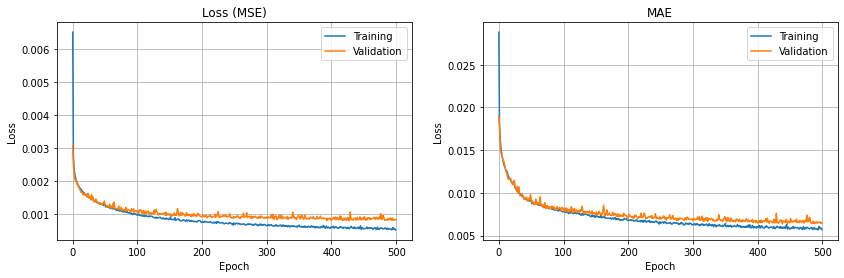

In [13]:
plt.figure(figsize=(14,4))
plt.subplot(121)
plt.title("Loss (MSE)")
plt.plot(history.history["loss"], label="Training")
plt.plot(history.history["val_loss"], label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.subplot(122)
plt.title("MAE")
plt.plot(history.history["mae"], label="Training")
plt.plot(history.history["val_mae"], label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

## Quick Test

In [14]:
X_test_scaled = ff_scaler.transform(X_test)
y_predict_scaled = model.predict(X_test_scaled)
y_predict = y_predict_scaled / current_scaler

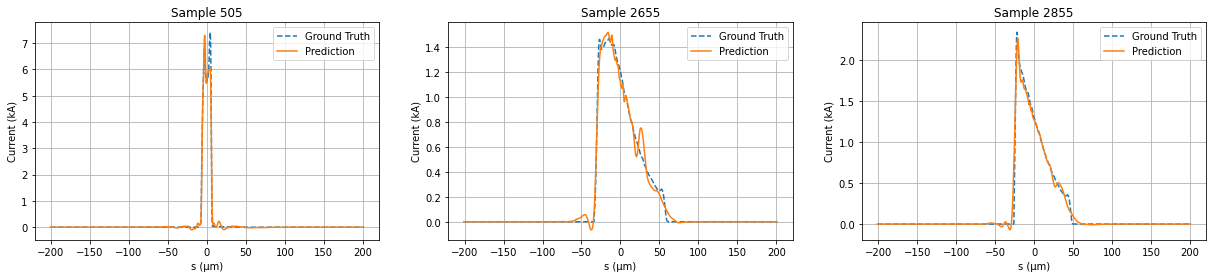

In [20]:
samples = np.random.randint(0, len(y_predict), size=3)

plt.figure(figsize=(21,4))
for i, sample in enumerate(samples):
    plt.subplot(1, 3, i+1)
    plt.title(f"Sample {sample}")
    plt.plot(new_s*1e6, y_test[sample]*1e-3, ls="--", label="Ground Truth")
    plt.plot(new_s*1e6, y_predict[sample]*1e-3, label="Prediction")
    plt.xlabel("s (μm)")
    plt.ylabel("Current (kA)")
    plt.legend()
    plt.grid()
plt.show()

## Evaluation

In [16]:
X_test_scaled = ff_scaler.transform(X_test)
y_test_scaled = y_test * current_scaler

In [17]:
score = model.evaluate(X_test_scaled, y_test_scaled, batch_size=64)

64/64 [==============================] - 0s 2ms/step - loss: 8.3658e-04 - mae: 0.0065
